# Visualize LOCA with HUC watersheds and choose cells of interest

August Posch --- February-March 2025

This notebook reads in HUC-10 watershed shapefile, latitudes and longitudes of LOCA gridcell centers, and a land shapefile. It identifies the gridcells of interest and saves them as a .npy file. Along the way it saves two figures showing a map with gridcells of interest starred as well as the watersheds and land.

In [1]:
parameters = {
    'path_HUC-10': '../data/WBD_01_HU2_Shape/Shape/WBDHU10.shp',
    'path_for_loading_lats': '../data/auxil/lats_locane.npy',
    'path_for_loading_lons': '../data/auxil/lons_locane.npy',
    'path_land_shp': '../data/auxil/ecoreg/ECOREGIONS_POLY.shp',
    'path_first_fig': '../figures/LOCA_gridcells_view1.png',
    'path_second_fig': '../figures/LOCA_gridcells_view2.png',
    'path_for_saving_gridcells_npy': '../data/auxil/loca_cells_of_interest_boston.npy'
}

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

Read in HUC-10 watersheds

In [3]:
gdf = gpd.read_file(parameters['path_HUC-10'])

Limit to just the five HUC-10 watersheds we care about

In [4]:
watersheds = ['Lower Charles River','Neponset River','Boston Harbor-Massachusetts Bay','Mystic River','Hingham Bay']

Cut down the Boston Harbor watershed to only include the parts where T stations are (because the other parts don't flow into the T station parts)

In [5]:
box = Polygon([(-80,30),(-71.0,30),(-71.0,50),(-80,50)])
box_gdf = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4269')
harbor = gdf[gdf.name=='Boston Harbor-Massachusetts Bay']
harbor_core = harbor.overlay(box_gdf)

In [6]:
well_behaved_watersheds = ['Lower Charles River','Neponset River','Mystic River','Hingham Bay']

In [7]:
filt = pd.concat([gdf[gdf.name.isin(well_behaved_watersheds)], harbor_core])

<Axes: >

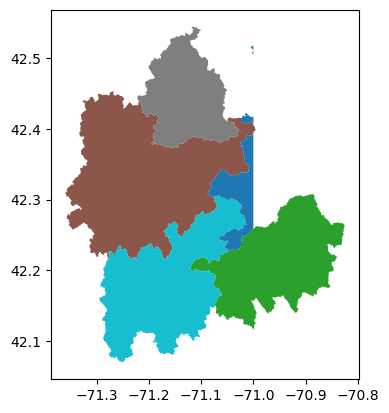

In [8]:
filt.plot('name')

Note that this is already plotted in lat and lon - but we will need to convert the LOCA longitudes by 360 degrees.

Visualize on a map of lat lon
(note: the lats and lons refer to the centers of the gridcells)

In [9]:
lats = np.load(parameters['path_for_loading_lats'])
lons = np.load(parameters['path_for_loading_lons'])

In [10]:
lons_new = lons - 360

Initial visualization:

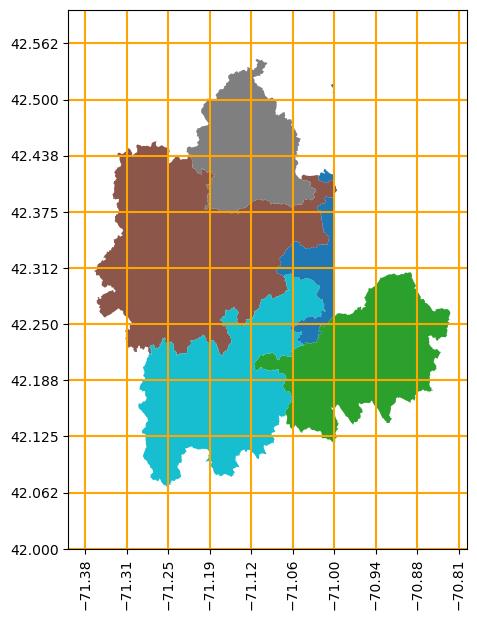

In [11]:
filt.plot('name', figsize=(7,7))
plt.xticks(ticks=lons_new-0.03125, rotation=90)
plt.yticks(ticks=lats-0.03125)
plt.xlim(-71.4,-70.8)
plt.ylim(42.0,42.6)
plt.hlines(lats-0.03125, -71.4,-70.4, color='orange')
plt.vlines(lons_new-0.03125, 42.0,42.7, color='orange')


# Find which LOCA gridcells to use

Get all lat-lon combos. Then see which ones intersect with the watersheds and with land.

In [12]:
# Get all lon-lat combos
lonlat = []
p_lonlat = []
for x in lons_new:
    for y in lats:
        lonlat.append((x,y))
        p_lonlat.append(Point(x,y))

In [13]:
gdf_p_lonlat = gpd.GeoDataFrame(geometry=p_lonlat, crs='EPSG:4269')

Import a Massachusetts shapefile to get land

In [14]:
ecoreg = gpd.read_file(parameters['path_land_shp'])

In [15]:
land = ecoreg.dissolve().to_crs('EPSG:4269') # dissolve the polygons together to get all Massachusetts land

<Axes: >

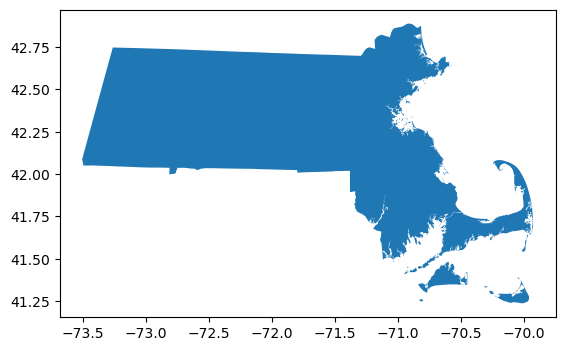

In [16]:
land.plot()

Limit to cells of interest, based on which gridcell centers overlap with the watersheds of interest.

In [17]:
cells_of_interest = gdf_p_lonlat.clip(filt)
#.clip(land) 

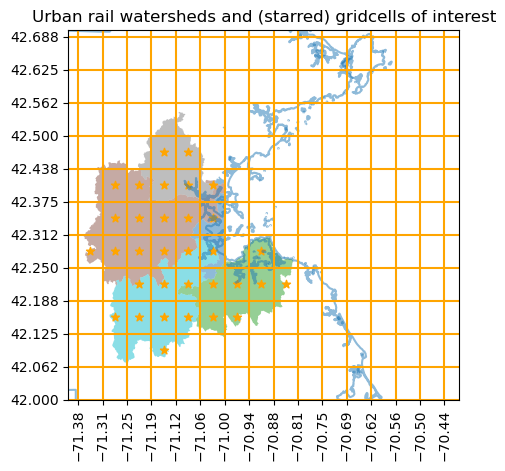

In [18]:
fig, ax = plt.subplots(1,1)
filt.plot('name', alpha=0.5, ax=ax)
land.boundary.plot(ax=ax, alpha=0.5)
cells_of_interest.plot(ax=ax, marker='*', color='orange')
plt.xticks(ticks=lons_new-0.03125, rotation=90)
plt.yticks(ticks=lats-0.03125)
plt.xlim(-71.4,-70.4)
plt.ylim(42.0,42.7)
plt.hlines(lats-0.03125, -71.4,-70.4, color='orange')
plt.vlines(lons_new-0.03125, 42.0,42.7, color='orange')
plt.title('Urban rail watersheds and (starred) gridcells of interest')

plt.savefig(parameters['path_first_fig'])


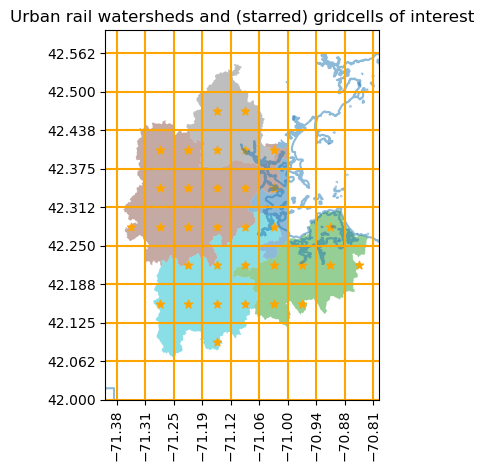

In [19]:
fig, ax = plt.subplots(1,1)
filt.plot('name', alpha=0.5, ax=ax)
land.boundary.plot(ax=ax, alpha=0.5)
cells_of_interest.plot(ax=ax, marker='*', color='orange')
plt.xticks(ticks=lons_new-0.03125, rotation=90)
plt.yticks(ticks=lats-0.03125)
plt.xlim(-71.4,-70.8)
plt.ylim(42.0,42.6)
plt.hlines(lats-0.03125, -71.4,-70.4, color='orange')
plt.vlines(lons_new-0.03125, 42.0,42.7, color='orange')
plt.title('Urban rail watersheds and (starred) gridcells of interest')

plt.savefig(parameters['path_second_fig'])


#### Save down the gridcells of interest.

Convert Point items to tuples.

In [20]:
cells_list = []
for cell in cells_of_interest['geometry']:
    cells_list.append(cell.coords[0])

In [21]:
cells_array = np.array(cells_list)
ca = np.column_stack([cells_array[:,0]+360,cells_array[:,1]]) # Adjusts lon back into positive Degrees East
np.save(parameters['path_for_saving_gridcells_npy'], ca)